In [8]:
import glob
import os
import pandas as pd
import numpy as np
import pickle
import textblob
# pip install textblob

In [9]:
train_directory = "E:/UNI/DM/Labs/Lab09/large_movie_review_dataset/train/"
test_directory = "E:/UNI/DM/Labs/Lab09/large_movie_review_dataset/test/"

def read_class(directory, klass):
    '''
    directory : directory path "~train or ~test"
    klass : "neg" or "pos"

    returns : list of stored reviews and their class
    '''
    reviews = []
    os.chdir(directory+klass)
    for file in glob.glob("*.txt"):
        with open(file, encoding="utf8") as f:
            data = f.read()
            reviews.append([data.lower(), klass])
    return reviews

In [11]:
# Read Training reviews from disk
neg_reviews_train = read_class(train_directory, "neg")
pos_reviews_train = read_class(train_directory, "pos")
neg_df_tr = pd.DataFrame(neg_reviews_train)
pos_df_tr = pd.DataFrame(pos_reviews_train)
train_data = pos_df_tr.append(neg_df_tr, ignore_index=True)

# Read Test reviews from disk
neg_reviews_test = read_class(test_directory, "neg")
pos_reviews_test = read_class(test_directory, "pos")
neg_df_te = pd.DataFrame(neg_reviews_test)
pos_df_te = pd.DataFrame(pos_reviews_test)
test_data = pos_df_te.append(neg_df_te, ignore_index=True)

# save a pickle of dataframes for easy loading

directory = 'E:/UNI/DM/Labs/Lab09/'
save_to_disk = (train_data, test_data)
with open(directory+'test&traindata.pickle', 'wb') as f:
    pickle.dump((save_to_disk), f)

In [12]:
# load Dataframe Pickles

directory = 'E:/UNI/DM/Labs/Lab09/'
with open(directory+'test&traindata.pickle', 'rb') as f:
    train_data, test_data = pickle.load(f)

In [13]:
class PickleObject():
    '''
    This Object will be saved to disk as a pickle after training
    '''
    def __init__(self, klasses, dicts, V, word_count, prob_klasses, rmv_stpwrd, alpha):
        # class labels
        self.klasses = klasses
        # dictionaries
        self.dicts = dicts
        # Vocabulary Count
        self.V = V
        # Wordcount of each class
        self.word_count = word_count
        # prob of each class
        self.prob_klasses = prob_klasses
        # whether trained with or without stopwords
        self.rmv_stpwrd = rmv_stpwrd
        # alpha smoothing value
        self.alpha = alpha

In [14]:
class NaiveBayes:
    def __init__(self, data=None, load_from_disk=False, path=None):
        '''
        data = None or pandas DataFrame
        load_from_disk = False(if data is given) or True
        path = pickle name(will write this object with loaded pickle)
        '''

        if data is None and load_from_disk == False:
            raise Exception(
                'Either pass data or give a path to load dictionaries from disk')

        if load_from_disk:
            # Load Saved Dictionaries
            if path == None:
                raise Exception('Please enter a valid Path')
            else:
                self.load_dictionaries(path)

        else:
            self.trained = False
            self.docs = data

    # Private Method
    def __tokenize(self, doc: str):
        from collections import Counter
        counts = Counter(doc.split())
        return dict(counts)

    # Private Method
    def __remove_punctuation(self, doc: str):
        
        '''
        remove punctuation marks in the given string
        '''

        punctuation = ['!', '"', '#', '$', '%', '&', "'", '(', ')',
                       '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?',
                       '@', '[', '\\', 'br', ']', '^', '_', '`', '{', '|', '}', '~']

        for pm in punctuation:
            doc = doc.replace(pm, ' ')

        return doc

    # Private Method
    def __remove_stopwords(self, doc: str):
        
        '''
        remove Stop words in the given string
        '''

        from nltk.corpus import stopwords
        words = stopwords.words('english')

        for wrd in words:
            doc = doc.replace(' '+wrd+' ', ' ')

        return doc

    def train_NB(self,alpha = 1, remove_stop_words=False):
        '''
        Trains Classifier

        alpha : alpha smooting value, default is 1

        remove_stop_words : whether to remove the stop words or not

        returns : prior, |V|, list of dictionaries (words and their frequencies in each class)

        '''
        if self.docs is None:
            raise Exception('Trained NB is loaded from disk.\
                                No documnets available for Training')
        if alpha < 1:
            raise Exception('Alpha should be >= 1')

        # class Labels
        self.klasses = list(self.docs[1].unique())
        self.dicts = []
        # Vocabulary count
        self.V = 0
        self.alpha = alpha
        self.word_count = []
        self.prob_klasses = []
        self.rmv_stpwrd = remove_stop_words
        strs = []

        for klass in self.klasses:
            docs = self.docs[self.docs[1] == klass][0].as_matrix()
            self.prob_klasses.append(len(docs)/len(self.docs))

            # Pre Processing text
            doc_string = " ".join(docs)
            doc_string = self.__remove_punctuation(doc_string)
            if remove_stop_words:
                doc_string = self.__remove_stopwords(doc_string)

            # make dictionary
            dic = self.__tokenize(doc_string)
            strs.append(doc_string)
            self.word_count.append(len(doc_string.split()))
            self.dicts.append(dic)

        # Num of Unique words in all documents
        self.V = len(set(" ".join(strs).split()))
        # Only save to disk if NB is trained
        self.trained = True

        return self.prob_klasses, self.V, self.dicts

    def save_dictionaries(self, path):
        '''
        Saves dictionaries and other values required for prediction to the disk.

        path : path of pickle file to be stored

        '''

        if not self.trained:
            raise Exception('!! Nothing to save !! Train First')

        save_to_disk = PickleObject(self.klasses, self.dicts, self.V,
        self.word_count, self.prob_klasses, self.rmv_stpwrd, self.alpha)
        
        with open(path, 'wb') as f:
            pickle.dump(save_to_disk, f)

    def load_dictionaries(self, path):
        
        '''
        Loads dictionaries and other values required for prediction from the disk.

        path : path of pickle file to be stored

        '''

        with open(path, 'rb') as f:
            pickle_obj = pickle.load(f)

        self.klasses = pickle_obj.klasses
        self.dicts = pickle_obj.dicts
        self.V = pickle_obj.V
        self.word_count = pickle_obj.word_count
        self.prob_klasses = pickle_obj.prob_klasses
        self.rmv_stpwrd = pickle_obj.rmv_stpwrd
        self.alpha = pickle_obj.alpha
        self.trained = True

    def predict(self, rev: str):

        '''
        Given a new review classify it into a class

        rev : string to be classified

        '''

        # Pre process the test review
        rev = rev.lower()
        rev = self.__remove_punctuation(rev)
        if self.rmv_stpwrd:
            rev = self.__remove_stopwords(rev)
        uniq_words = set(rev.split())
        dic = self.__tokenize(rev)

        # list of probabilities that rev belongs to a klass
        klass_scores = []
        for idx, _ in enumerate(self.klasses):
            # log of probability of a class
            score = np.log(self.prob_klasses[idx])
            for uw in uniq_words:
                # if word is not in dictionary
                if self.dicts[idx].get(uw) is None:
                    # numerator
                    num = self.alpha
                else:
                    num = self.dicts[idx].get(uw) + self.alpha
                # denominator
                den = self.word_count[idx] + (self.alpha * self.V)
                power = dic.get(uw)
                score += np.log((num/den) ** power)
            klass_scores.append(score)
        klass_index = np.argmax(klass_scores)
        # return predicted class label
        return self.klasses[klass_index]

    def evaluate(self, df):

        '''
        Evaluate a given pandas dataframe

        df : pandas dataframe

        returns : accuracy of the classifier 
        '''

        correct_preds = 0
        klasses = list(df[1].unique())
        for klass in klasses:

            revs = list(df[df[1] == klass][0])
            for rev in revs:
                prediction = xb.predict(rev)

                if prediction == klass:
                    correct_preds += 1

        return correct_preds / len(df)

In [15]:
# directory to store pickle
direc = 'E:/UNI/DM/Labs/Lab09/'

nb = NaiveBayes(data=train_data)
nb.train_NB(alpha = 3)
nb.save_dictionaries(direc + 'withsw.pickle')

# Trained NB after removing Stop Words
nbsw = NaiveBayes(data=train_data)
nbsw.train_NB(alpha = 3, remove_stop_words=True)
nbsw.save_dictionaries(direc + 'withoutsw.pickle')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:90: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [16]:
direc = 'E:/UNI/DM/Labs/Lab09/'

xb = NaiveBayes(load_from_disk=True, path=direc + 'withsw.pickle')

print("Accuracy with stop words : ",xb.evaluate(test_data))


xb = NaiveBayes(load_from_disk=True, path=direc + 'withoutsw.pickle')

print("Accuracy without stop words : ",xb.evaluate(test_data))

Accuracy with stop words :  0.81296
Accuracy without stop words :  0.83296


In [17]:
pos_dict = xb.dicts[0]
neg_dict = xb.dicts[1]
sorted_pos_dict = {k: v for k, v in 
                        sorted(pos_dict.items(), key=lambda item: item[1], reverse= True)}

sorted_neg_dict = {k: v for k, v in 
                        sorted(neg_dict.items(), key=lambda item: item[1], reverse= True)}

top = 10
neg_top = list(sorted_neg_dict.keys())[:top]
pos_top = list(sorted_pos_dict.keys())[:top]
print("Top {} words".format(top))
print(".:    pos   neg",end='\n\n')

for i in range(top):
    print(i+1,': ',pos_top[i],' ',neg_top[i])

Top 10 words
.:    pos   neg

1 :  film   movie
2 :  movie   film
3 :  one   one
4 :  like   like
5 :  good   even
6 :  story   good
7 :  time   bad
8 :  great   would
9 :  well   really
10 :  see   time


In [18]:
class InformationRetrieval:

    def __init__(self, data):
        self.data = data

    def __remove_stopwords(self, doc: str):
        from nltk.corpus import stopwords
        words = stopwords.words('english')
        for wrd in words:
            doc = doc.replace(' '+wrd+' ', ' ')
        return doc

    def __remove_punctuation(self, doc: str):
        punctuation = ['!', '"', '#', '$', '%', '&', "'", '(', ')',
                       '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?',
                       '@', '[', '\\', 'br', ']', '^', '_', '`', '{', '|', '}', '~']
        for pm in punctuation:
            doc = doc.replace(pm, ' ')
        return doc

    def vectorize_data(self):
        '''
        make W list containing all unique words
        '''
        doc_string = " ".join(self.data)
        doc_string = self.__remove_punctuation(doc_string)
        doc_string = self.__remove_stopwords(doc_string)
        self.W = list(set(doc_string.split()))

    def __cosine_similarity(self, a, b):
        '''
        return cosine similarity b/w a and b
        '''
        return np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))

    def __bag_of_words_vector(self, doc: str):
        '''
        return bag_of_words_vector of doc based on W list
        '''
        
        from collections import Counter

        vec = np.zeros(len(self.W))
        dic = dict(Counter(doc.split()))
        for j in range (len(self.W)):
            count = dic.get(self.W[j])
            if count is None:
                count = 0
            vec[j] = count
        return vec

    def find_similar_docs(self, doc: str, n = 1):
        '''
        return n (default: 1) similar docs to doc based on cosine similarity
        '''
        cosine_vector = np.zeros(len(self.data))

        a = self.__bag_of_words_vector(doc)

        for i in range(len(self.data)):

            b = self.__bag_of_words_vector(self.data[i])

            cosine_vector[i] = self.__cosine_similarity(a,b)
        
        # top num docs with highest cosine similarity
        sim = np.argpartition(cosine_vector, n)[::-1][:n]

        return self.data[sim]

In [19]:

# docs to find similarity with
ir = InformationRetrieval(train_data[0][:2000])

# make W list containing all unique words
ir.vectorize_data()

# doc : list ot top n documents matching the given document
docs = ir.find_similar_docs(train_data[0][2002], 2)

print(*docs, sep='\n\n')


lars von trier's europa is a worthy echo of the third man, about an american coming to post-world war ii europe and finds himself entangled in a dangerous mystery.<br /><br />jean-marc barr plays leopold kessler, a german-american who refused to join the us army during the war, arrives in frankfurt as soon as the war is over to work with his uncle as a sleeping car conductor on the zentropa railway. what he doesn't know is the war is still secretly going on with an underground terrorist group called the werewolves who target american allies. leopold is strongly against taking any sides, but is drawn in and seduced by katharina hartmann (barbara sukowa), the femme fatale daughter of the owner of the railway company. her father was a nazi sympathizer, but is pardoned by the american colonel harris (eddie considine) because he can help get the german transportation system up and running again. the colonel soon enlists, or forces, leopold to be a spy (without giving him a choice or chance 

In [20]:
print(train_data[0][2002])

this isn't the best bigfoot ever made, but by the recent standards of nature gone awry movies, mostly showing on the sci-fi channel, this is quality stuff. it has some action, some humor, decent f/x and bigfoot. cg is used, but so are some practical f/x, which i like.<br /><br />overall this movie is worth a watch if you are a fan of b horror/sci-fi and need a fix. it's better than the movie sasquatch and not a sequel to it, so don't be fooled.<br /><br />the acting is better than you may expect to find in a movie like this and the directing is more than adequate. expect a bit of a lul as the characters are "developed", but know that things will pick up. if you are watching a dvd you may want to skip a chapter or two.


In [21]:
# number of documents to analyse

top = 500

polarities = []

for doc in train_data[0][:top]:
    polarities.append(TextBlob(doc).polarity)

# number of (most +ve or most -ve) documnets to filter
num = 3

list_most_neg = np.argpartition(polarities, num)[:num]

list_most_pos = np.argpartition(polarities, num)[::-1][:num]

most_pos = train_data[0][list_most_pos]

most_neg = train_data[0][list_most_neg]

print(*most_neg, sep='\n\n\n')


guinea pig: the devil's experiment is without a doubt ***** stars on first view, its a raw realistic creepy and disturbing look into the dark side of human nature. this movie gets right to the point, you may be thinking what point? the point is to satisfy fan's of just extreme violence and gore. this movie has some gore, more or less just torturing a women violently. there are really only 3 scene's that could be considered gore. i'll tell you one thing though guinea pig: the devil's experiment makes hostile look like sesame street. if you thought hostile was a crazy brutal disturbing torture flick then you ain't seen the half of it until you've seen guinea pig: the devil's experiment.<br /><br />movie rating 0-5, gore 0-10<br /><br />guinea pig: the devil's experiment (uncut) ***** (7)


this film deals with the atrocity in derry 30 years ago which is commonly known as bloody sunday.<br /><br />the film is well researched, acted and directed. it is as close to the truth as we will get 

In [22]:

polarities = []

for doc in train_data[0]:
    polarities.append(TextBlob(doc).polarity)

pol_df = pd.DataFrame(polarities)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002C40C43A748>]],
      dtype=object)

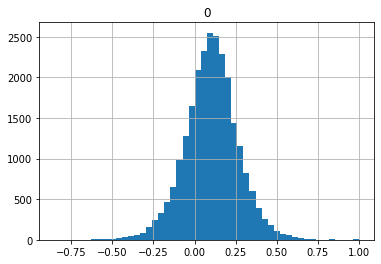

In [24]:
pol_df.hist(bins = 50)
# Plotted histogram shows that more than half of the reviews in train data have +ve polarity